In [1]:
#ante-MMPBSA.py -p 0.15_80_10_pH7.5_6m0j_trunc_final.top -r ACE2_dry_trunc.prmtop -l SARS-CoV-2-spike_dry_trunc.prmtop -m :1-339
# WARNING: -m is recepter residue number not atom number
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
import importlib
import keras.backend as K
from sklearn.utils import shuffle

%cd ../../PGGCN/
import models.layers_update_mobley as layers
importlib.reload(layers)
from models.dcFeaturizer import atom_features as get_atom_features
%cd ../Notebooks/Entropy



c:\Users\ali80\Desktop\GBNN-master\PGGCN
c:\Users\ali80\Desktop\GBNN-master\Notebooks\Entropy


In [2]:
def featurize(molecule, info, exclude=None):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        if exclude != None:
            for i in exclude:
                new_feature.pop(i)

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)


In [3]:

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([-.2, -1, 1, 1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38-1:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return model_var


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [4]:
def train(X, y, excelude):
    ex = len(excelude)
    m = PGGCNModel(num_atom_features = 36-ex)
    m.addRule("sum", 0, 31-ex)
    m.addRule("multiply", 31-ex, 33-ex)
    m.addRule("distance", 33-ex, 36-ex)

    m.compile(loss=pure_rmse, optimizer='adam')
    X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]

    input_shapes = []
    for i in range(len(X_train)):
        input_shapes.append(np.array(X_train[i]).shape[0])
    m.set_input_shapes(input_shapes)
    for i in range(len(X_train)):
        if X_train[i].shape[0] < 2000:
            new_list = np.zeros([2000 - X_train[i].shape[0], X_train[i].shape[-1]])
            X_train[i] = np.concatenate([X_train[i], new_list], 0)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    hist = m.fit(X_train, y_train, epochs = 40, batch_size=64)

    input_shapes = []
    y_test = y[int(.8*len(X)):]
    for i in range(len(X_test)):
        input_shapes.append(np.array(X_test[i]).shape[0])
    m.set_input_shapes(input_shapes)
    for i in range(len(X_test)):
        if X_test[i].shape[0] < 2000:
            new_list = np.zeros([2000 - X_test[i].shape[0], 40])
            X_test[i] = np.concatenate([X_test[i], new_list], 0)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return m.evaluate(X_test, y_test), hist


In [5]:
def experiment(excelude):
    PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
    df = pd.read_csv('T_data.csv')
    info = []
    for pdb in list(PDBs.keys()):
        info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])
    X = []
    y = []

    for i, pdb in enumerate(list(PDBs.keys())):
        X.append(featurize(PDBs[pdb], info[i], excelude))
        y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])


    return train(X, y , excelude)
    

In [6]:
excelude_list = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 18, 19]
dic = {}
for ex in excelude_list:
    hist, res = experiment([ex])
    dic[ex] = [hist, res]

Epoch 1/40
1/1 [==============================] - 210s 210s/step - loss: 1.7192
Epoch 2/40
1/1 [==============================] - 0s 354ms/step - loss: 1.7171
Epoch 3/40
1/1 [==============================] - 1s 850ms/step - loss: 1.7151
Epoch 4/40
1/1 [==============================] - 1s 775ms/step - loss: 1.7130
Epoch 5/40
1/1 [==============================] - 1s 802ms/step - loss: 1.7110
Epoch 6/40
1/1 [==============================] - 1s 790ms/step - loss: 1.7089
Epoch 7/40
1/1 [==============================] - 1s 798ms/step - loss: 1.7069
Epoch 8/40
1/1 [==============================] - 1s 730ms/step - loss: 1.7049
Epoch 9/40
1/1 [==============================] - 1s 817ms/step - loss: 1.7028
Epoch 10/40
1/1 [==============================] - 1s 906ms/step - loss: 1.7008
Epoch 11/40
1/1 [==============================] - 1s 632ms/step - loss: 1.6989
Epoch 12/40
1/1 [==============================] - 1s 907ms/step - loss: 1.6969
Epoch 13/40
1/1 [==============================]

In [7]:
dic

{0: [3.188767194747925, <keras.src.callbacks.History at 0x22123645890>],
 1: [3.1927220821380615, <keras.src.callbacks.History at 0x2212c730f90>],
 2: [3.187455654144287, <keras.src.callbacks.History at 0x2226de40b50>],
 3: [3.1886086463928223, <keras.src.callbacks.History at 0x22278ce7e50>],
 4: [3.189476251602173, <keras.src.callbacks.History at 0x2236862dc50>],
 6: [3.1934866905212402, <keras.src.callbacks.History at 0x223e5215c50>],
 7: [3.189481496810913, <keras.src.callbacks.History at 0x22461e6fc50>],
 8: [3.1873693466186523, <keras.src.callbacks.History at 0x224a7e52d90>],
 10: [3.1908986568450928, <keras.src.callbacks.History at 0x22559518b90>],
 11: [3.189535617828369, <keras.src.callbacks.History at 0x225d6570b90>],
 12: [3.184943675994873, <keras.src.callbacks.History at 0x2264f98e6d0>],
 18: [3.1894543170928955, <keras.src.callbacks.History at 0x226cfb83890>],
 19: [3.192228317260742, <keras.src.callbacks.History at 0x226cfd866d0>]}

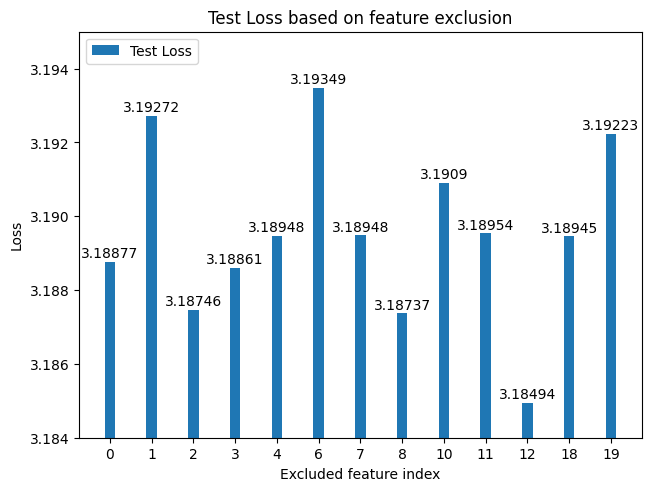

In [84]:

items = [f"{str(i)}"  for i in list(dic.keys())]
loss = [i[0] for i in list(dic.values())]

test_loss = {
    'Test Loss': [i[0] for i in list(dic.values())],
}

x = np.arange(len(items)) 
width = 0.25 

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_loss.items():
    rects = ax.bar(x , measurement, width, label=attribute)
    ax.bar_label(rects, padding=1)

ax.set_ylabel('Loss')
ax.set_xlabel('Excluded feature index')

ax.set_title('Test Loss based on feature exclusion')
ax.set_xticks(x, items)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(3.184, 3.195)

plt.show()


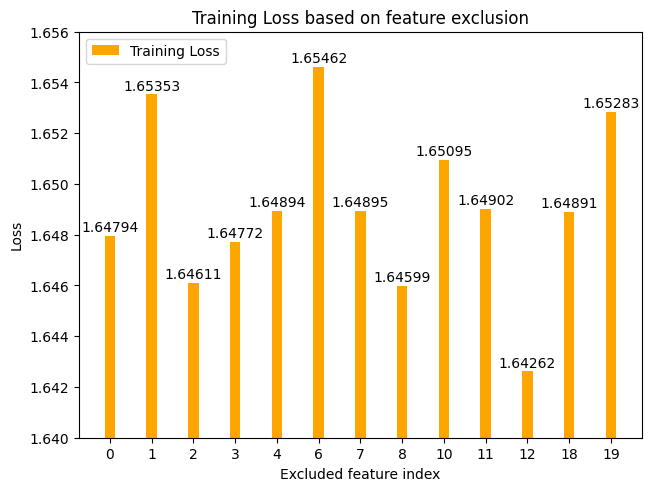

In [77]:

items = [f"{str(i)}"  for i in list(dic.keys())]

train_loss = {
    'Training Loss': [i[-1].history['loss'][-1] for i in list(dic.values())],
}

x = np.arange(len(items)) 
width = 0.25  

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in train_loss.items():
    rects = ax.bar(x , measurement, width, label=attribute, color = 'orange')
    ax.bar_label(rects, padding=1)

ax.set_ylabel('Loss')
ax.set_xlabel('Excluded feature index')

ax.set_title('Training Loss based on feature exclusion')
ax.set_xticks(x, items)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(1.64, 1.656)

plt.show()
